In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
import re
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import sem

# import sklearn
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline

In [4]:
# paths
base_dir = '/Users/jenndisanto/Documents/2022/changlab-rotation/data/logfiles'

# get list of files
files = glob.glob('%s/EC*.csv' % (base_dir))

# put all data into one dataframe
dfs = list()
subjects = list()
for f in files:
    subject = re.search("EC\d\d\d", f).group()

    df = pd.read_csv(f)
    df = df[np.array([str(s) != 'nan' for s in df['stim_number']])]

    if df['block_type'].unique() == 2:  # mirror the data scale for block types 2

        d = df['slider.response'].values
        d = np.abs(d - 11)
        df['slider.response'] = d
    
    if subject not in subjects: subjects.append(subject)
    dfs.append(df)

df = pd.concat(dfs)
df = df.reset_index()

#define consistent plot order, color legend
wordpair_order = [35, 2, 11] #bp, bm, dn
left_words = ['penecillin','bountiful','desolate'] #based on morph/audio 001.wav file
right_words = ['beneficial','mountains','necessary']
colors = ['purple','orange'] #left words = purple, right words = orange
dark_colors = ['indigo','darkorange']

In [7]:
print(np.__version__)

1.19.5


In [99]:
# def to_flip(row, pp):
#     flip = 0
#     if row.word_end[0] == pp[0]:
#         if row.word_side == 'right': flip = 1
#     if row.word_end[0] == pp[1]:
#         if row.word_side == 'left': flip = 1

#     return flip

def to_flip(row, w):
    if w in ['beneficial','bountiful','necessary']: flip = False
    if w in ['penecillin','mountains','desolate']: flip = True
    return flip

def d_flip(row):
    d = row['slider.response']
    if row.flip == True: d = np.abs(d - 11)
    return d

def w_end(row, w):
    if w in ['beneficial','bountiful','necessary']: word_end = 1
    if w in ['penecillin','mountains','desolate']: word_end = 2
    return word_end

# for curve fitting
def fsigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def aggregate(x, y):
    sorted_x = np.sort(df_sub['morph_n'].unique())
    print(x==sorted_x[0])
    return sorted_x, [y[x==val].mean() for val in sorted_x]

def draw_true_line(x):
    y = (0.9/5)*x-0.08
    return y

def flip_slider(w):
    # find the continuum step
    if w in ['beneficial','bountiful','necessary']:   #b->r, b->l, n->r
        w_left = w
        flip = False

    elif w in ['penecillin','mountains','desolate']:   #p->l, m->r, d->l
        w_right = w
        flip = True

    else:
        print("Cannot find pair...")
    
    return flip

In [122]:
# plot behaviour
def plot_behaviour(df, subject, true_line, horiz_line):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex='col', sharey='col')
    axs = axs.flatten()
    
    for si, stim_val in enumerate(wordpair_order):    #df['stim_number'].unique()
        # subset
        df_sub = df.query("stim_number == @stim_val")   # get only the data for the word-pair

        # get stim phoneme pair and word
        pp = df_sub['phoneme_pair'].values[0]
        w1, w2 = left_words[si], right_words[si]

        # loop through words in pair
        for wi, w in enumerate([w1, w2]):   #i.e. for beneficial, penicilin

            flip = flip_slider(w)
    
            datas = list()
            d_s = list()
            d_avg_morph = list()
            morphs = list()
            for morph_n in range(1, 7):
                morph_n = str(morph_n)
                df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")

                d = df_sub_morph['slider.response'].values
                d = np.array(d, dtype='float')
                
                # flip data so that the x-axis means identical acoustic input
                if flip:
                    d = np.abs(d - 11)

                # plot data
              
                axs[si].plot([int(morph_n)]*len(d), d/10., 'o', color='k', ms=0.1)

                if len(d) > 0:
                    datas.append(d / 10.)
                    d = d / 10.
                    d_s += d.tolist()
                    d_avg_morph.append(np.mean(d))
                    morphs += [int(morph_n)]*len(d)
                else:
                    datas.append([0]*20)

            axs[si].violinplot(datas, range(1, 7),
                               showmeans=True, widths=1., showextrema=False,
                               points=50)
           
    
            #plot sigmoid
            p0 = [np.max(d_s), np.median(morphs), 1, np.min(d_s)]  #initial guess

            x = np.arange(1,7)
            popt, pcov = curve_fit(sigmoid, morphs, d_s, p0, method='lm')
            x_smooth = np.linspace(1,6,1000)
            y = sigmoid(x_smooth, *popt)
            axs[si].plot(x_smooth, y, color=colors[wi], label=w) 
            
            if horiz_line:
                horizontal = [.5]*len(x_smooth)
                axs[si].plot(x_smooth, horizontal, color='k')
                idx = np.argwhere(np.diff(np.sign(y - horizontal))).flatten() #find intersection with sigmoid
                if idx.size > 0:
                    axs[si].plot(x_smooth[idx], 0.5, 'ro')
    
        if true_line:
            #line x=y
            axs[si].plot([1, 6], [0.1, 1.0], color='k')
            y_true = draw_true_line(x_smooth)
            axs[si].plot(x_smooth, y_true, color='k')
        
        
        # labels
        if s != 0:
            axs[si].set_title('%s: %s-%s' % (subject, left_words[si], right_words[si]), fontsize=8)
        else:
            axs[si].set_title('%s-%s' % (left_words[si], right_words[si]), fontsize=8)

        #set axis labels as phonemes
        axs[si].set_xticklabels([' ', pp[0], ' ', ' ', ' ', ' ', pp[1], ' '])
        axs[si].locator_params(nbins=10, axis='y')
        axs[si].set_yticklabels([' ', pp[0], ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', pp[1]])
        

    #         axs[si].axis('off')    
    
    axs[2].set_xlabel('Morph Step')
    axs[2].set_ylabel('Slider Response')
    plt.show()
    return fig

In [90]:
# plot bias at slider=0.5
def plot_bias5(df, subject):

    word_order = [35, 2, 11] #bp, bm, dn
    x_intersect = list()
    for si, stim_val in enumerate(word_order):    #df['stim_number'].unique()
        # subset
        df_sub = df.query("stim_number == @stim_val")   # get only the data for the word-pair

        # get stim phoneme pair and word
        pp = df_sub['phoneme_pair'].values[0]
        w1, w2 = left_words[si], right_words[si]

        # loop through words in pair
        for wi, w in enumerate([w1, w2]):   #i.e. for beneficial, penicilin

            flip = flip_slider(w)
    
            datas = list()
            d_s = list()
            d_avg_morph = list()
            morphs = list()
            for morph_n in range(1, 7):
                morph_n = str(morph_n)
                df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")

                d = df_sub_morph['slider.response'].values
                d = np.array(d, dtype='float')
                
                # flip data so that the x-axis means identical acoustic input
                if flip:
                    d = np.abs(d - 11)

                if len(d) > 0:
                    datas.append(d / 10.)
                    d = d / 10.
                    d_s += d.tolist()
                    d_avg_morph.append(np.mean(d))
                    morphs += [int(morph_n)]*len(d)
                else:
                    datas.append([0]*20)

           
    
            # compute and plot curve
            p0 = [np.max(d_s), np.median(morphs), 1, np.min(d_s)]

            x = np.arange(1,7)
            popt, pcov = curve_fit(sigmoid, morphs, d_s, p0, method='lm')
            x_smooth = np.linspace(1,6,1000)
            y = sigmoid(x_smooth, *popt)
            
            y_closest = min(y, key=lambda x:abs(x-0.5))
            y = y.tolist()
            idx = y.index(y_closest)
            if np.abs(y_closest - 0.5) < 0.02:
                x_intersect.append(x_smooth[idx])
            else:
                x_intersect.append(-1)
 
    return x_intersect

No handles with labels found to put in legend.
No handles with labels found to put in legend.


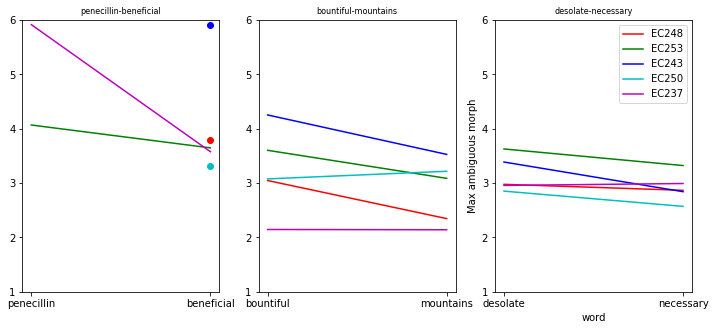

In [119]:
x_s = np.zeros((len(subjects),6))
x_avg = np.zeros((len(subjects),3))
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex='col')
subject_colors = ['r','g','b','c','m']
for i, s in enumerate(subjects):
    df_s = list()
    for j, file in enumerate(files):
        if s in file: df_s.append(dfs[j])
            
    df_s = pd.concat(df_s)
    df_s = df_s.reset_index()
    x = plot_bias5(df_s, s) #gets sigmoid intersection with y=0.5 for ea word, put in array x
    #fix -1 values
#     x_fix = x.copy()
#     for k, x_k in enumerate(x):
#         if x_k == -1:
#             if k % 2 == 0: #only 2nd word 
#                 x_fix[k] = x[k+1]
#             else:
#                 x_fix[k] = x[k-1]
    x_avg[i,:] = [np.mean(x[0:2]), np.mean(x[2:4]), np.mean(x[4:6])]
#     x_s[s,:] = x

#     words = ['beneficial','penecillin','bountiful','mountains','necessary','desolate']
    for si, stim_val in enumerate(wordpair_order):
        idx = si * 2
        if x[idx] == -1: #some of the left words don't intersect y=0.5 line
            axs[si].plot(1, x[idx+1], 'o', c=subject_colors[i])
        else:
            axs[si].plot([0,1], [x[idx], x[idx+1]], c=subject_colors[i], label=s)
        axs[si].set_title('%s-%s' % (left_words[si], right_words[si]), fontsize=8)
        axs[si].set_ylim([1, 6])
        axs[2].set_ylabel('Max ambiguous morph')
        axs[si].locator_params(nbins=2, axis='x')
        axs[2].set_xlabel('word')
        axs[si].set_xticklabels([' ', left_words[si], right_words[si]])
        axs[2].legend()
fig.savefig('all_subjects_lexbias', bbox_inches='tight', format='pdf')

Text(0, 0.5, 'Max ambiguous morph')

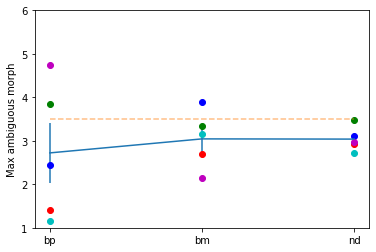

In [235]:
colors = ['r','g','b','c','m']
for i, s in enumerate(subjects):
    plt.plot(['bp','bm','nd'], x_avg[i,:],'o', c=colors[i])

x = ['bp','bm','nd']
y = [np.mean(x_avg[:,0]), np.mean(x_avg[:,1]), np.mean(x_avg[:,2])]
plt.errorbar(x,y,yerr=[sem(x_avg[:,0]), sem(x_avg[:,1]), sem(x_avg[:,2])])
plt.plot([x[0], x[2]], [3.5,3.5], '--', alpha=0.5)
plt.ylim([1, 6])
plt.ylabel('Max ambiguous morph')

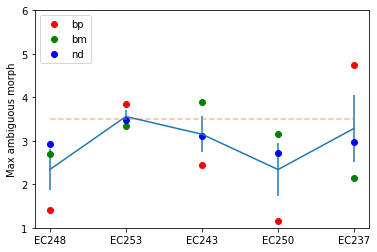

In [232]:
colors = ['r','g','b']
labels = ['bp','bm','nd']
for i in range(3):
    plt.plot(subjects, x_avg[:,i],'o', c=colors[i], label=labels[i])

y = [np.mean(x_avg[i,:]) for i in range(5)]
plt.errorbar(subjects, y, yerr=[sem(x_avg[i,:]) for i in range(5)])
plt.plot([subjects[0],subjects[4]], [3.5,3.5], '--', alpha=0.5)
plt.ylim([1, 6])
plt.ylabel('Max ambiguous morph')
plt.legend(loc='upper left')

In [37]:
# plot bias at slider=0.5
def get_ambiguous_sliders(df, subject, amb_range):

    word_order = [35, 2, 11] #bp, bm, dn

    ds_all = list()
    morphs_all = list()
    words_all = list()
    for si, stim_val in enumerate(word_order):    #df['stim_number'].unique()
        # subset
        df_sub = df.query("stim_number == @stim_val")   # get only the data for the word-pair

        # get stim phoneme pair and word
        pp = df_sub['phoneme_pair'].values[0]
        w1, w2 = left_words[si], right_words[si]

        # loop through words in pair
        for wi, w in enumerate([w1, w2]):   #i.e. for beneficial, penicilin

            flip = flip_slider(w)

            for morph_n in range(1, 7):
                morph_n = str(morph_n)
                df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")

                d = df_sub_morph['slider.response'].values
                d = np.array(d, dtype='float')
                
                # flip data so that the x-axis means identical acoustic input
                if flip:
                    d = np.abs(d - 11)
                d = d / 10.
                d_range_idx = np.where((d>=amb_range[0]) & (d<=amb_range[1]))
                d_range = d[d_range_idx]
                ds_all += d_range.tolist()
                morphs_all += [int(morph_n)]*len(d_range)
                words_all += [stim_val]*len(d_range)
    
    range_data = np.empty((len(ds_all), 3))
    range_data[:,0] = ds_all
    range_data[:,1] = morphs_all
    range_data[:,2] = words_all
    return range_data

1076


Text(0, 0.5, '0.5 Slider Responses')

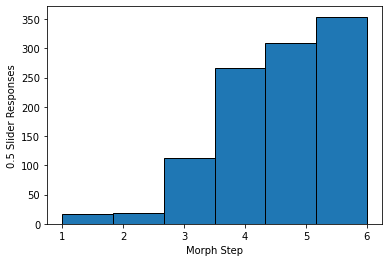

In [342]:
range_data = get_ambiguous_sliders(df, 0, [0.8, 1])
plt.hist(range_data[:,1], bins=6, edgecolor='black')
print(len(range_data))
plt.xlabel('Morph Step')
plt.ylabel('0.5 Slider Responses')

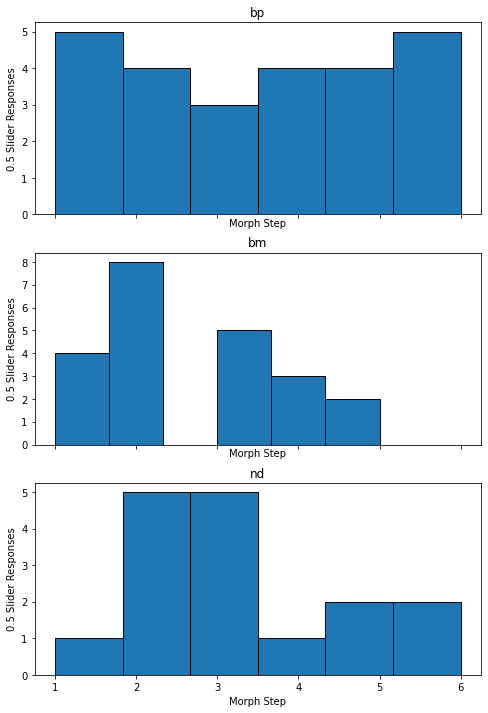

In [338]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
axs = axs.flatten()
range_data = get_ambiguous_sliders(df, 0, [0.45, 0.55])
word_order = [35, 2, 11] #bp, bm, dn
words = ['bp','bm','nd']
for si, stim_val in enumerate(word_order):
    w = range_data[:,2]
    idx = np.where(w==stim_val)

    axs[si].hist(range_data[idx,1][0], bins=6, edgecolor='black')
    axs[si].set_xlabel('Morph Step')
    axs[si].set_ylabel('0.5 Slider Responses')
    axs[si].set_title(words[si])

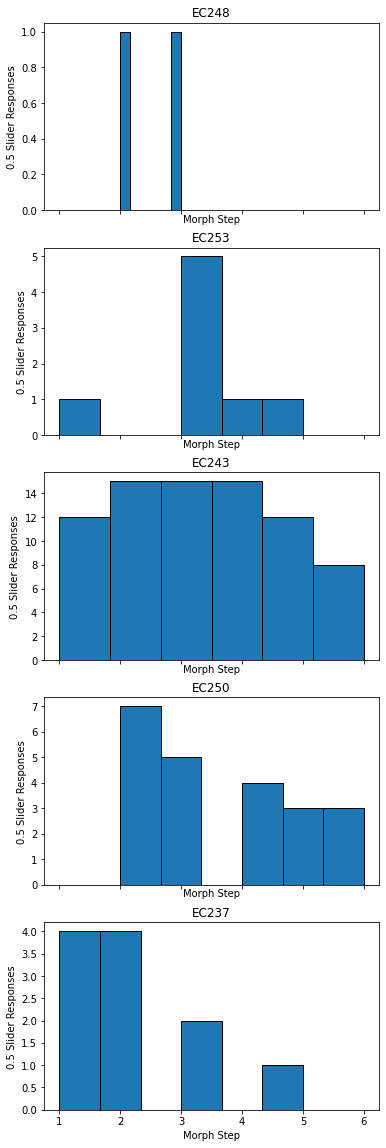

In [343]:
#individual subjects
fig, axs = plt.subplots(5, 1, figsize=(6, 20), sharex=True)
axs = axs.flatten()

# plts = PdfPages('individuals_sigmoid_trueline.pdf')
for i, s in enumerate(subjects):
    df_s = list()
    for j, file in enumerate(files):
        if s in file: df_s.append(dfs[j])
            
    df_s = pd.concat(df_s)
    df_s = df_s.reset_index()
    range_data = get_ambiguous_sliders(df_s, s, [0.4, 0.6])
    axs[i].hist(range_data[:,1], bins=6, edgecolor='black')
    axs[i].set_xlabel('Morph Step')
    axs[i].set_ylabel('0.5 Slider Responses')
    axs[i].set_title(s)

#     plts.savefig(plot)
    
# plts.close()     

In [86]:
# plot behaviour
def plot_bias(df, subject):
    fig, axs = plt.subplots(3, 3, figsize=(18, 12), sharex=True)
#     axs = axs.flatten()
    word_order = [35, 2, 11] #bp, bm, dn
    for si, stim_val in enumerate(word_order):    #df['stim_number'].unique()
        # subset
        df_sub = df.query("stim_number == @stim_val")   # get only the data for the word-pair

        # get stim phoneme pair and word
        pp = df_sub['phoneme_pair'].values[0]
        w1, w2 = left_words[si], right_words[si]

        # loop through words in pair
        for wi, w in enumerate([w1, w2]):   #i.e. for beneficial, penicilin

            flip = flip_slider(w)
            
            datas = list()
            d_s = list()
            d_avg_morph = list()
            morphs = list()
            biases = list()
            neg_bias = list()
            pos_bias = list()
            for morph_n in range(1, 7):
                morph_n = str(morph_n)
                df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")

                d = df_sub_morph['slider.response'].values

                d = np.array(d, dtype='float')
                # flip data so that the x-axis means identical acoustic input
                if flip:
                    d = np.abs(d - 11)

                if len(d) > 0:
                    datas.append(d / 10.)
                    d = d / 10.
                    d_s += d.tolist()
                    d_avg_morph.append(np.mean(d))
                    morphs += [int(morph_n)]*len(d)
                    
                    #compute distance from true line
                    bias = d - draw_true_line(int(morph_n))
                    
                    #sum absolute value of bias
                    biases.append(sum(np.abs(bias)))
                    
                    # positive bias = lexical, negative = acoustic
                    if w in left_words: bias = -1 * bias
                    idx = np.where(bias < 0)
                    sum_neg_bias = sum(np.abs(bias[idx]))
                    
                    idx = np.where(bias > 0)
                    sum_pos_bias = sum(bias[idx])
                    
                    #positivie is lexical bias, negative is acoustic
                    neg_bias.append(100 * sum_neg_bias / (sum_neg_bias + sum_pos_bias))
                    pos_bias.append(100 * sum_pos_bias / (sum_pos_bias + sum_neg_bias))
                    

                else:
                    datas.append([0]*20)

            # plot bar - total bias
            axs[0,si].bar(np.arange(1,7), biases, color=colors[wi], label=w, alpha = 0.5)
            axs[0,si].legend()
            
            width = 0.25
            axs[wi+1,si].bar(np.arange(1,7), neg_bias, width=width, color=colors[wi], label='acoustic')
            axs[wi+1,si].bar(np.arange(1,7)+width, pos_bias, width=width, color=colors[wi], label='lexical', alpha = 0.5)
            axs[wi+1,1].legend()
            if wi == 0:
                title = left_words[si]
            else:
                title = right_words[si]
            axs[wi+1,si].set_title(title)
            axs[wi+1,0].set_ylabel('% of Total Error')
            axs[wi+1,0].set_xlabel('Morph Step')

        # labels
        axs[0,si].set_title('%s: %s-%s' % (subject, left_words[si], right_words[si]), fontsize=8)
        

    axs[0,0].set_xlabel('Morph Step')
    axs[0,0].set_ylabel('Total Error')
    plt.show()
    return fig

EC248


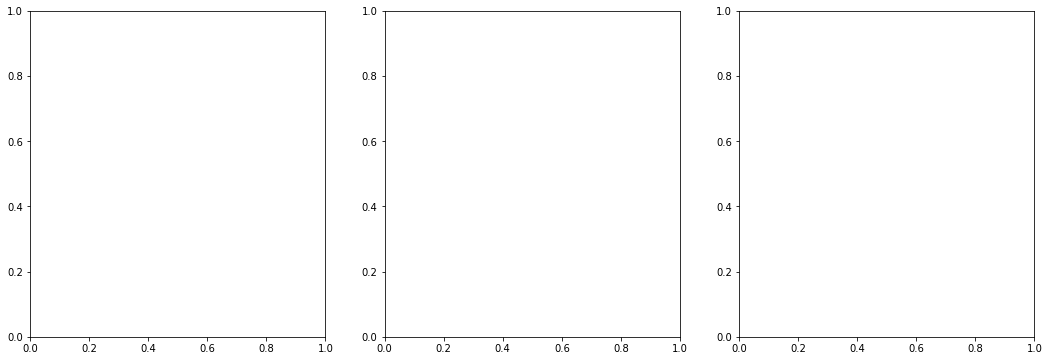

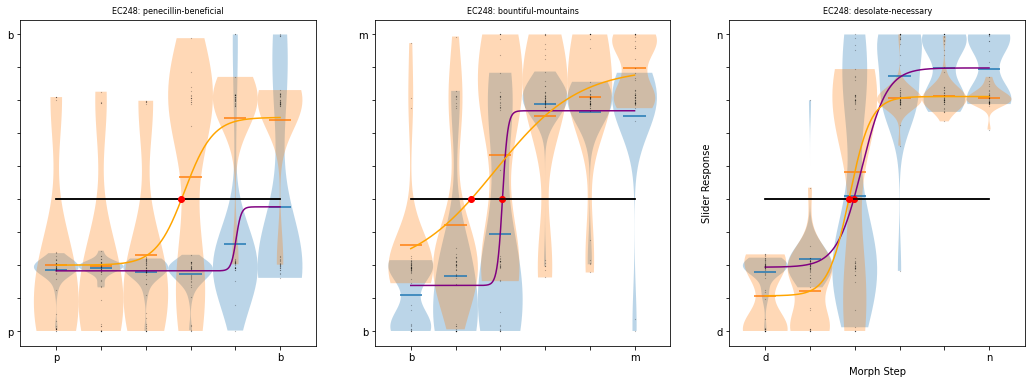

EC253


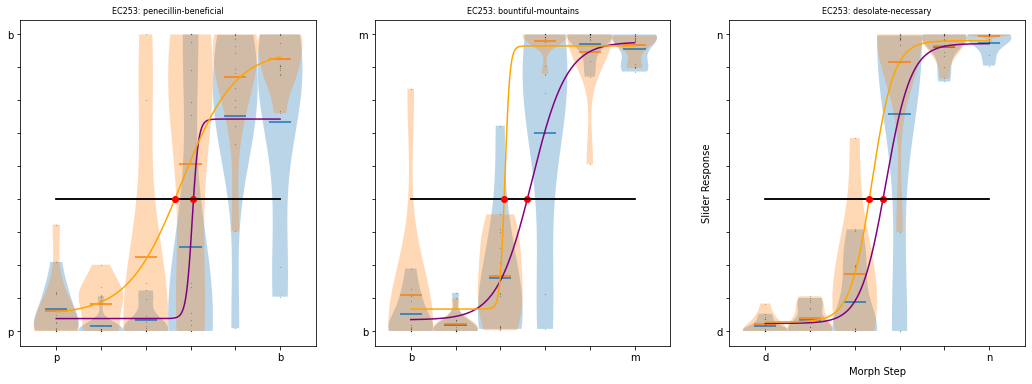

EC243


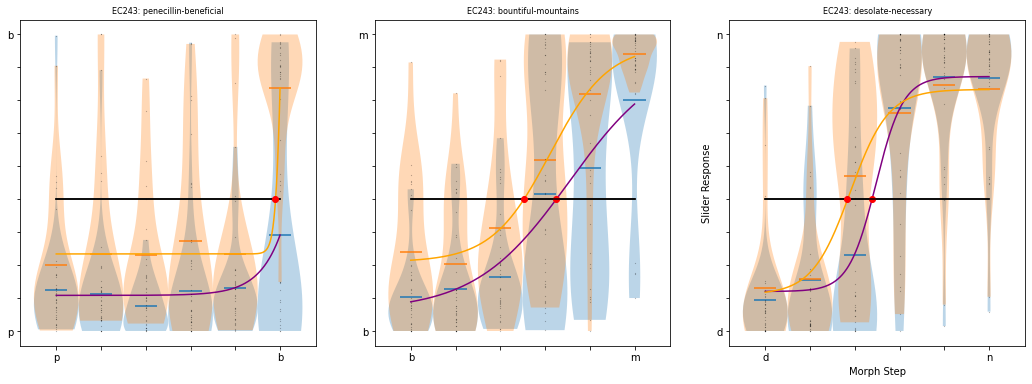

EC250


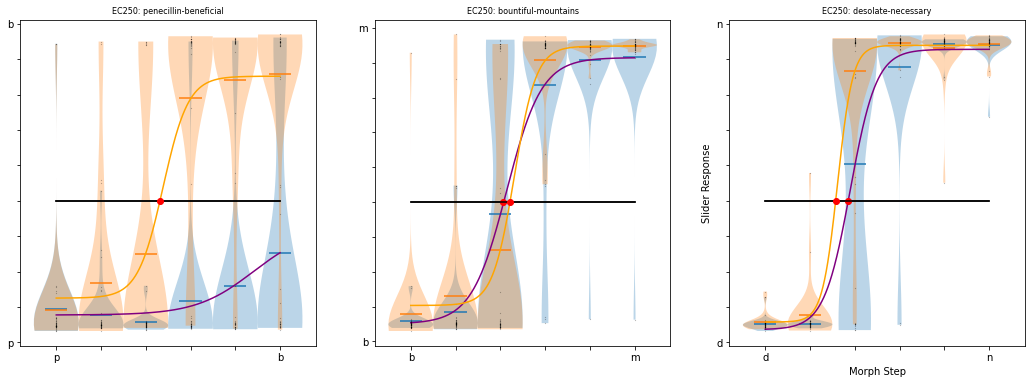

EC237


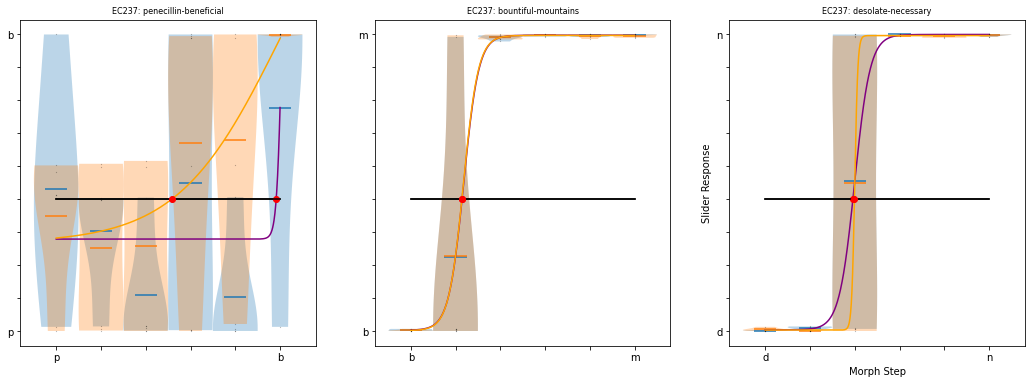

In [106]:
#individual subjects
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
axs = axs.flatten()

plts = PdfPages('individuals_sigmoid.pdf')
for s in subjects:
    df_s = list()
    for i, file in enumerate(files):
        if s in file: df_s.append(dfs[i])
            
    df_s = pd.concat(df_s)
    df_s = df_s.reset_index()
    print(s)
    plot = plot_behaviour(df_s, s, False, True)

    plts.savefig(plot)
    
plts.close()     

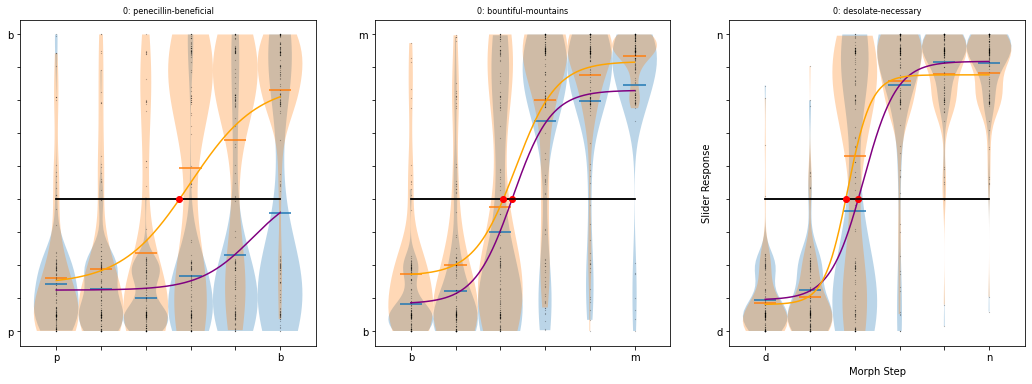

In [124]:
#plot average across individuals
fig = plot_behaviour(df, 0, False, True)
fig.savefig('all_subjects_sigmoid_5line', bbox_inches='tight', format='pdf')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


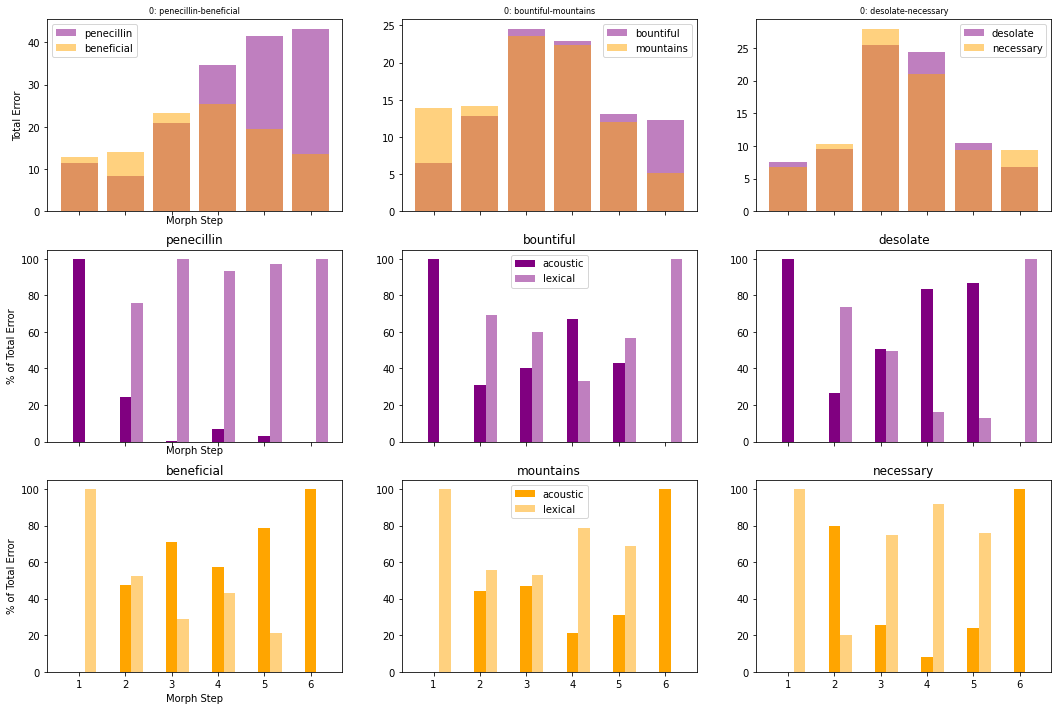

In [88]:
fig = plot_bias(df, 0)
fig.savefig('Error_distribution', bbox_inches='tight', format='pdf')

In [318]:
# plot regression - features: ambiguity? or morph, word_end
def plot_regression(df, word_pair, subject):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
    axs = axs.flatten()

    word_order = [35, 2, 11] #bp, bm, dn
    X = list()
    y = list()
    for si, stim_val in enumerate(word_order):    #for each word pair
        # subset
        df_sub = df.query("stim_number == @stim_val")   # get only the data for the word-pair

        # get stim phoneme pair and word
        pp = df_sub['phoneme_pair'].values[0]
        w1, w2 = np.unique(df_sub['word_end'])
        
        X_pair = list()
        y_pair = list()
        # loop through words in pair
        for w in [w1, w2]:   #for word in word pair

            # find the continuum step
            if w in ['beneficial','bountiful','necessary']:   #will end up left
                col = 'purple'
                w_left = w
                flip = False
                word_end = 1

            elif w in ['penecillin','mountains','desolate']:   #will end up right
                col = 'orange'
                w_right = w
                flip = True
                word_end = 2

                
            d_word = list()
            X_word = list()
            for morph_n in range(1, 7):
                morph_n = str(morph_n)
                df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")

                d = df_sub_morph['slider.response'].values
                d = np.array(d, dtype='float')
                
                if int(morph_n) <= 3:
                    ambiguity = int(morph_n)
                else:
                    ambiguity = 7 - int(morph_n)
                        
                # flip data so that the x-axis means identical acoustic input
                if flip:
                    d = np.abs(d - 11)

                if len(d) > 0:
                    d = d / 10.
                    d_word += d.tolist()
                    if word_pair:
                        x_morph = [[int(morph_n), ambiguity, word_end, ambiguity*word_end, si] for i in range(len(d))]
                    else:
                        x_morph = [[int(morph_n), ambiguity, word_end, ambiguity*word_end] for i in range(len(d))]
                    X_word += x_morph

            
            X_pair += X_word
            y_pair += d_word
        
        X += X_pair
        y += y_pair
        
        
        # fit regression for each word pair
        if not word_pair:
            pipe = make_pipeline(StandardScaler(), LinearRegression())      
            pipe.fit(X_pair, y_pair)
            score = pipe.score(X_pair, y_pair)
            print(score)

            reg = pipe.named_steps['linearregression']
            params = reg.coef_
            score1 = reg.score(X_pair, y_pair)
            print(params)


            axs[si].bar(['morph', 'ambiguity', 'word_end', 'amb*w_end'], [params[0], params[1], params[2], params[3]], label=w, alpha = 0.5)
            axs[si].set_title('%s: %s-%s' % (subject, w_left, w_right), fontsize=8)
    
    if word_pair:
        pipe = make_pipeline(StandardScaler(), LinearRegression())      
        pipe.fit(X, y)
        score = pipe.score(X, y)
        print(score)

        reg = pipe.named_steps['linearregression']
        params = reg.coef_
        score1 = reg.score(X, y)
        print(params)
        
        axs[0].bar(['morph', 'ambiguity', 'word_end', 'amb*w_end', 'word_pair'], [params[0], params[1], params[2], params[3], params[4]], label=w, alpha = 0.5)
        axs[0].set_title('%s' % (subject), fontsize=8)
    
    axs[0].set_ylabel('feature importance')
#     plt.show()
    return fig

0.47562793250422747
[ 0.23032849  0.04866762  0.00434812 -0.04656545  0.08451611]


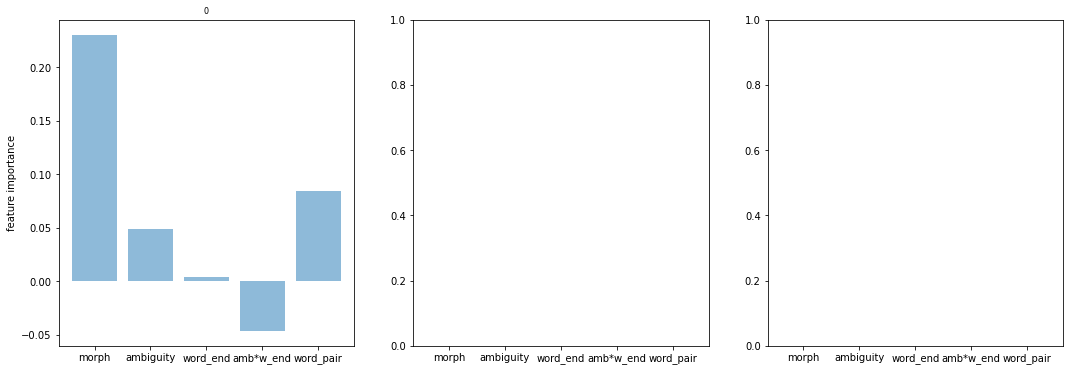

In [353]:
fig = plot_regression(df, True, 0)

EC248
0.4662443833824314
[ 0.19268689  0.05418504  0.02847367 -0.04560899  0.07688499]
EC253
0.6768341923956753
[ 3.25198368e-01  2.10857407e-03  3.14670139e-04 -3.48180508e-02
  4.14361383e-02]
EC243
0.40136872283140707
[ 0.19037625 -0.024665   -0.00951042 -0.00397192  0.09636999]
EC250
0.568631826689918
[ 0.26296379  0.11659077 -0.00366225 -0.09240629  0.10309068]
EC237
0.4594235638809151
[ 0.26994311  0.07001883 -0.01290799 -0.01603225  0.04513057]


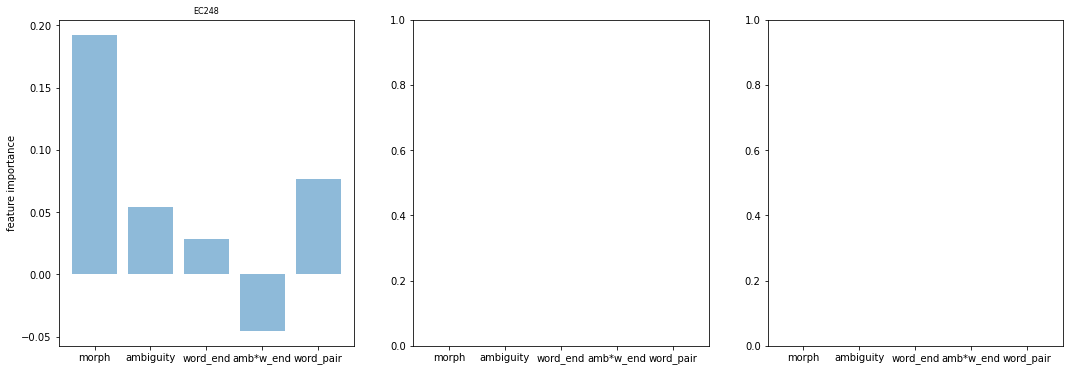

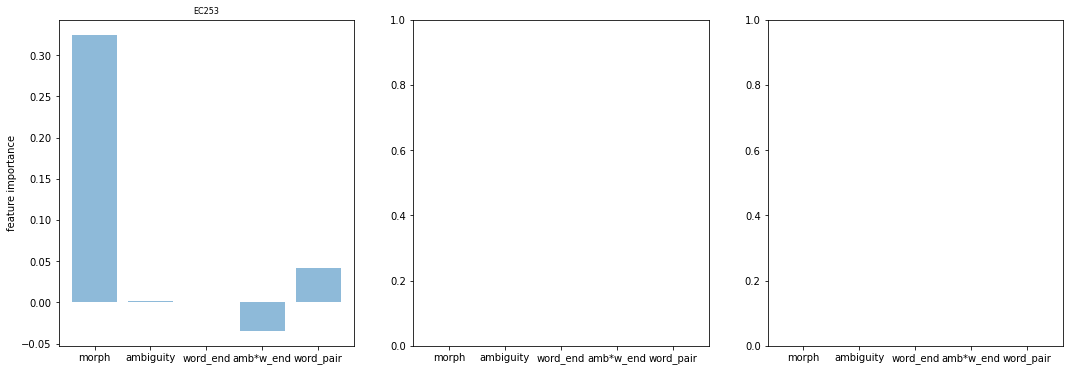

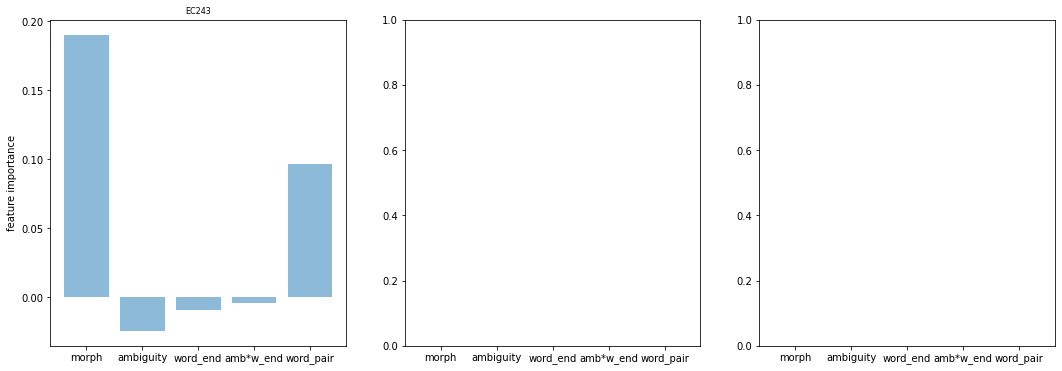

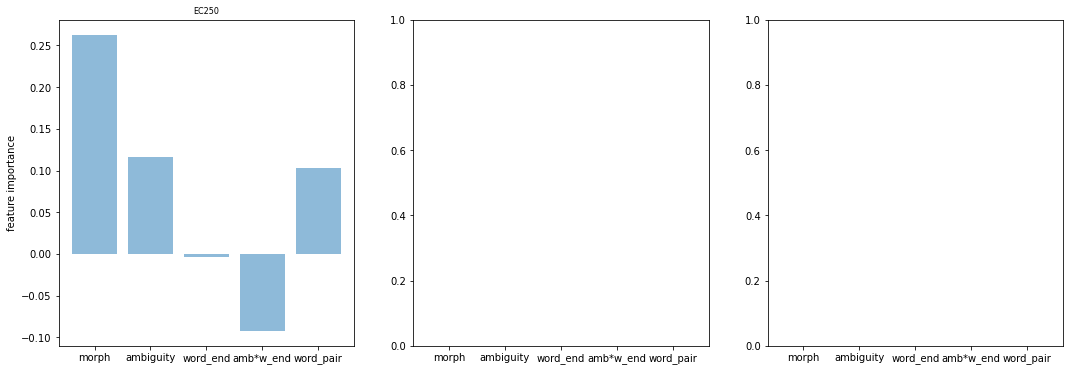

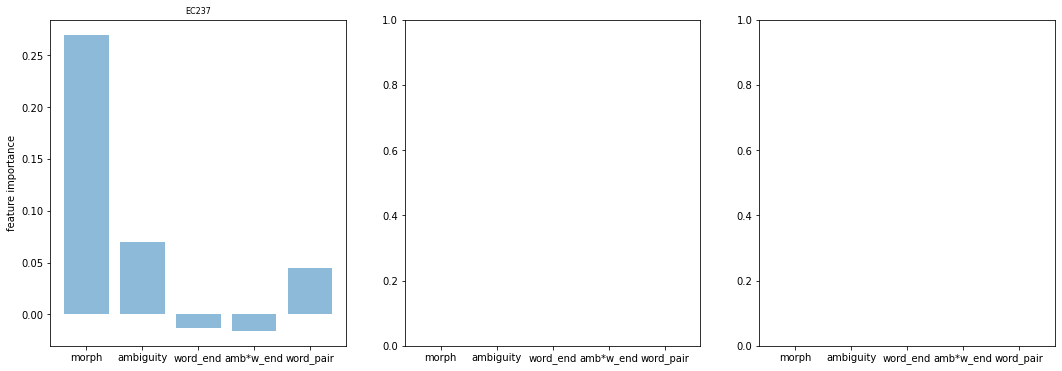

In [319]:
for s in subjects:
    df_s = list()
    for i, file in enumerate(files):
        if s in file: df_s.append(dfs[i])
            
    df_s = pd.concat(df_s)
    df_s = df_s.reset_index()
    print(s)
    plot = plot_regression(df_s, True, s)

In [27]:
#continuous vs categorical

from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema


def kde(df, s):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
    for si, stim in enumerate(np.unique(df['stim_number'].values)):
        df_sub = df.query("stim_number == @stim")

        d = df_sub['slider.response'].values
        d = np.array(d, dtype='float')

        
        kde = KernelDensity(kernel='gaussian', bandwidth=0.8).fit(d.reshape(-1, 1))
        s = np.linspace(0,10)
        e = kde.score_samples(s.reshape(-1,1))
        
        mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
        axs[si].plot(s, e)
        axs[si].plot(s[ma], e[ma], 'go', s[mi], e[mi], 'ro')


#         axs[si].set_ylim(0,20)
#         axs[2].set_xlabel('Slider Response')
#         axs[2].set_ylabel('Reaction Time')
    plt.show()
    return fig

EC248


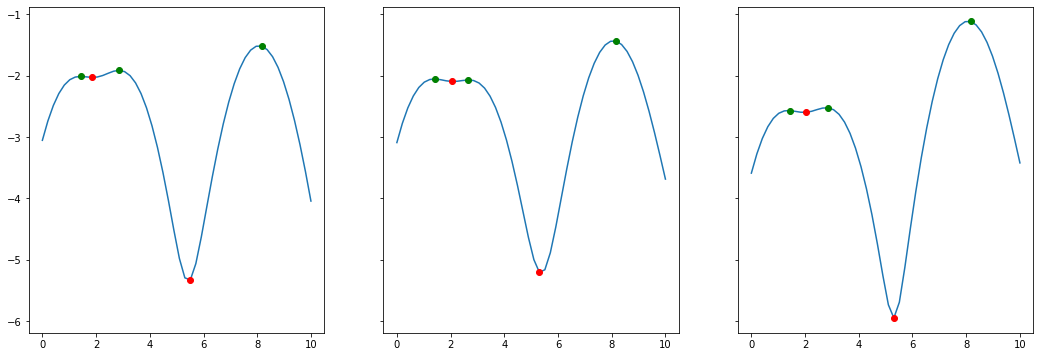

EC253


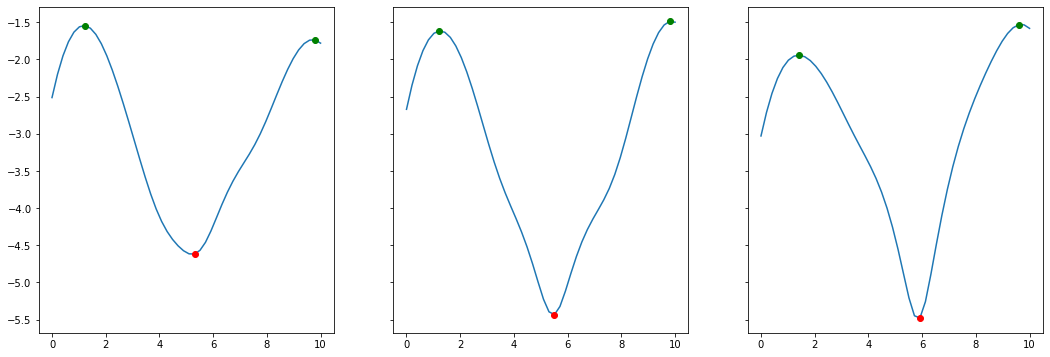

EC243


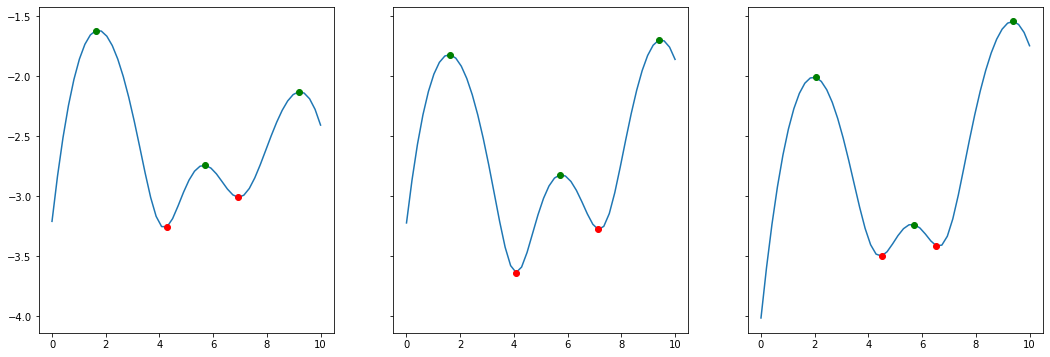

EC250


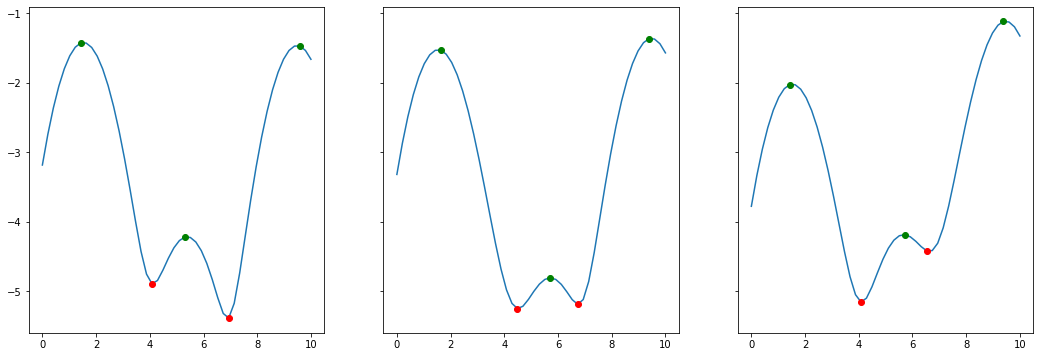

EC237


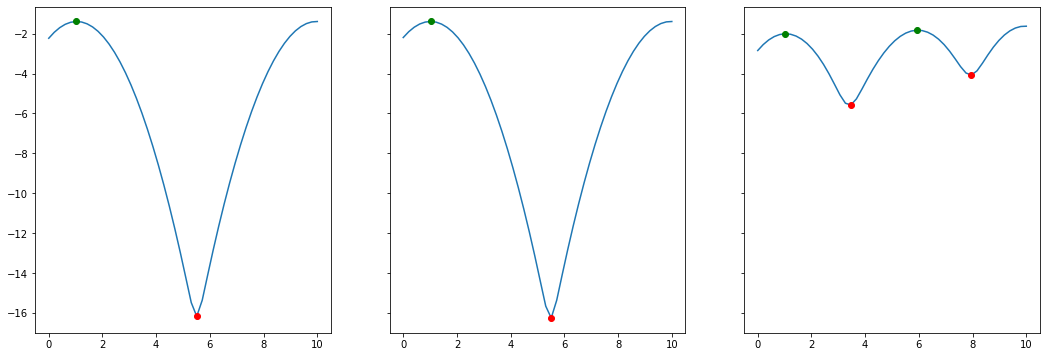

In [28]:
#individual subjects

# plts = PdfPages('individuals_sigmoid_trueline.pdf')
for s in subjects:
    df_s = list()
    for i, file in enumerate(files):
        if s in file: df_s.append(dfs[i])
            
    df_s = pd.concat(df_s)
    df_s = df_s.reset_index()
    print(s)
    plot = kde(df_s, s)

#     plts.savefig(plot)
    
# plts.close()     

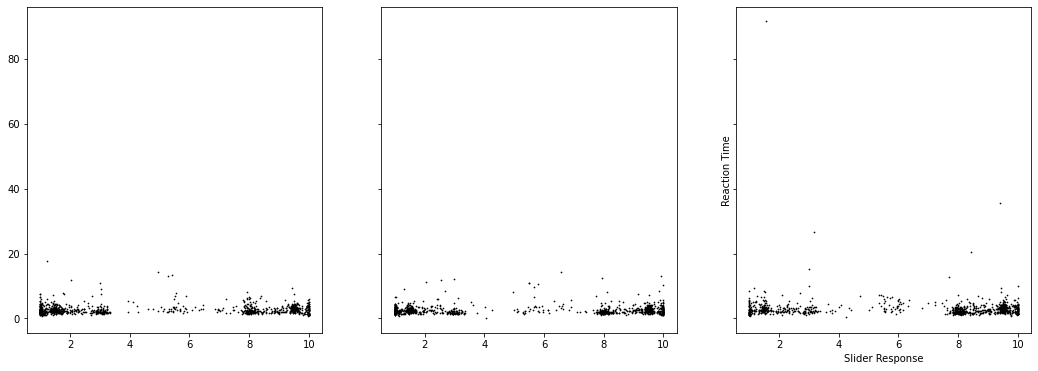

In [7]:
fig = plot_slider_rt(df,0)

beneficial
True
0       False
1       False
3        True
4       False
6        True
        ...  
2867    False
2876     True
2877    False
2878    False
2880    False
Name: morph_n, Length: 960, dtype: bool


IndexError: boolean index did not match indexed array along dimension 0; dimension is 80 but corresponding boolean dimension is 960

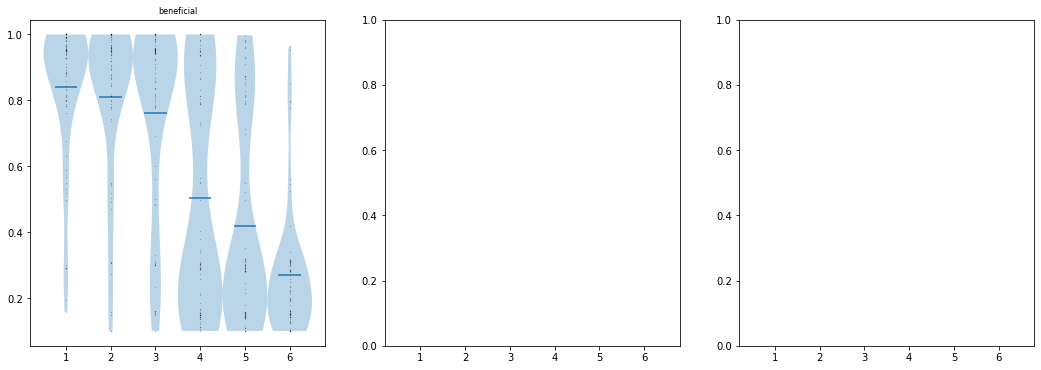

In [297]:
# plot behaviour
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
axs = axs.flatten()
for si, stim_val in enumerate(df['stim_number'].unique()):   #loop through word/phoneme pairs
#     print(si, stim_val)
    # subset for word pair
    df_sub = df.query("stim_number == @stim_val")
    

    # get stim phoneme pair and word
    pp = df_sub['phoneme_pair'].values[0]  #phoneme pair - pb, dn, bm
    w1, w2 = np.unique(df_sub['word_end'])
#     print(df_sub.head)
#     print(df_sub['word_side'].unique()[0])
    

    # loop through words
    for w in [w1, w2]:
#         df2 = df_sub.query('word_end == @w')
#         df2.to_csv('word_side_test.csv')
#         break
        # find the continuum step
        if w[0] == pp[0]:   #for penicilin, bountiful, desolate
            print(w)
            print(df_sub['word_side'].unique()[0] == 'left')
#             print(w[1])
            col = 'purple'
            if df_sub['word_side'].unique()[0] == 'left':
                flip = False
            else:
                flip = True
        elif w[0] == pp[1]:
            print(w)
            print(df_sub['word_side'].unique()[0] == 'left')
            col = 'orange'
            if df_sub['word_side'].unique()[0] == 'right':
                flip = False
            else:
                flip = True
        else:
            print("Cannot find pair...")

        datas = list()
#         print(datas)
        for morph_n in range(1, 7):
            morph_n = str(morph_n)
            df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")
            d = df_sub_morph['slider.response'].values

            d = np.array(d, dtype='float')
            # flip data so that the x-axis means identical acoustic input
            if flip:
                d = np.abs(d - 11)
            
            # plot data

            axs[si].plot([int(morph_n)]*len(d), d/10., 'o', color='k', ms=0.1)   #shows slider response per morph
            if len(d) > 0:
                datas.append(d / 10.)
            else:
                datas.append([0]*20)
#         print(len(datas[0]))
#         break
        axs[si].violinplot(datas, range(1, 7),
                           showmeans=True, widths=1., showextrema=False,
                           points=50)
        axs[si].set_title('%s' % (w1), fontsize=8)
#         break
        # compute and plot curve
        x, d_agg = aggregate(df_sub['morph_n'], d)
        p0 = [np.max(d_agg), np.median(x), 1, np.min(d_agg)]
        popt, pcov = curve_fit(sigmoid, x, d_agg, p0, method='lm')
        y = sigmoid(x, *popt)
        axs[si].plot(x, y, color=col, label=w)

        # labels
        axs[si].set_title('%s-%s' % (w1, w2), fontsize=8)
#         axs[si].axis('off')
# axs[2].set_xlabel('Morph Step')
# axs[2].set_ylabel('Slider Response')
# plt.show()
    break

#each x axis coordinate is the same acoustic evidence for first phoneme

#individual subjects


#averaging over word pairs - lexical bias by morph
#lexical bias vs chance (shuffle)
#ambiguity
#morph step (i.e. ambiguity), acoustic evidence, lexical bias
#regression with these factors

#trial notes- for each patient:
#barakeet blocks
#check whether bad

#lexical bias by ambiguity
#nonparametric stat test
#measure of fitting a line
#how far from the line - residuals get mean and std dev
#get means std dev,plots, then models
#direction of bias

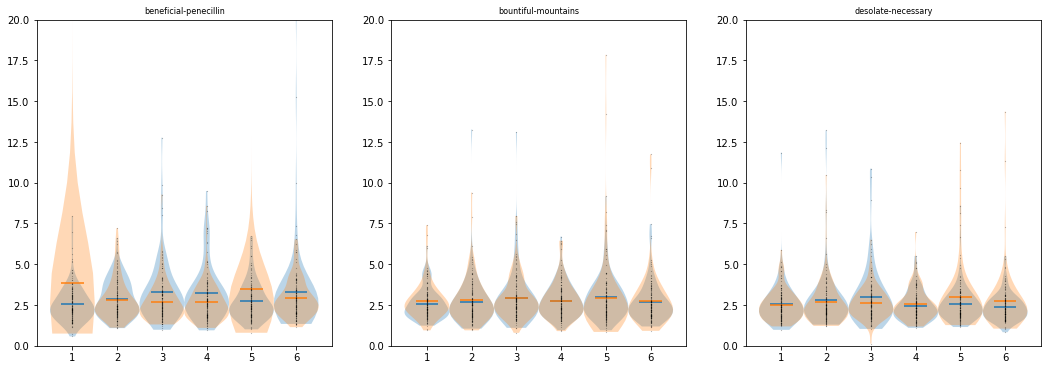

In [45]:
#plot behavior
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
axs = axs.flatten()
for si, stim_val in enumerate(df['stim_number'].unique()):   #loop through word/phoneme pairs

    # subset for word pair
    df_sub = df.query("stim_number == @stim_val")
    

    # get stim phoneme pair and word
    pp = df_sub['phoneme_pair'].values[0]  #phoneme pair - pb, dn, bm
    w1, w2 = np.unique(df_sub['word_end'])
#     print(df_sub.head)
#     print(df_sub['word_side'].unique()[0])
    

    # loop through words
    for w in [w1, w2]:

        # find the continuum step
        if w[0] == pp[0]:
#             print(w[1])
            col = 'purple'
            if df_sub['word_side'].unique()[0] == 'left':
                flip = False
            else:
                flip = True
        elif w[0] == pp[1]:
#             print(w)
            col = 'orange'
            if df_sub['word_side'].unique()[0] == 'right':
                flip = False
            else:
                flip = True
        else:
            print("Cannot find pair...")

        datas = list()
#         print(datas)
        d_max = []
        for morph_n in range(1, 7):
            morph_n = str(morph_n)
            df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")
            d = df_sub_morph['slider.rt'].values

            d = np.array(d, dtype='float')

            # flip data so that the x-axis means identical acoustic input
#             if flip:
#                 d = np.abs(d - 11)
#             print([int(morph_n)]*len(d))
            # plot data
            d_max.append(max(d))
            axs[si].plot([int(morph_n)]*len(d), d, 'o', color='k', ms=0.1)   #shows slider response per morph
            if len(d) > 0:
                datas.append(d)
            else:
                datas.append([0]*20)
#         print(len(datas[0]))
#         break
        axs[si].violinplot(datas, range(1, 7),
                           showmeans=True, widths=1., showextrema=False,
                           points=50)
            
#         axs[si].set_title('%s' % (w), fontsize=8)
#         print(d_max)
        axs[si].set_ylim([0, 20])
#         break
        # compute and plot curve
#         x, d_agg = aggregate(df_sub['morph_n'], d)
#         p0 = [np.max(d_agg), np.median(x), 1, np.min(d_agg)]
#         popt, pcov = curve_fit(sigmoid, x, d_agg, p0, method='lm')
#         y = sigmoid(x, *popt)
#         axs[si].plot(x, y, color=col, label=w)

        # labels
        axs[si].set_title('%s-%s' % (w1, w2), fontsize=8)
#         axs[si].axis('off')
# axs[2].set_xlabel('Morph Step')
# axs[2].set_ylabel('Slider Response')
# plt.show()


In [ ]:
## plot regression - features: ambiguity? or morph, word_end
def plot_regression(df, subject):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
    axs = axs.flatten()
    word_order = [35, 2, 11] #bp, bm, dn
    for si, stim_val in enumerate(word_order):    #for each word pair
        # subset
        df_sub = df.query("stim_number == @stim_val")   # get only the data for the word-pair

        # get stim phoneme pair and word
        pp = df_sub['phoneme_pair'].values[0]
        w1, w2 = np.unique(df_sub['word_end'])
        
        X_pair = list()
        y_pair = list()
        # loop through words in pair
        for w in [w1, w2]:   #for word in word pair
#             #flip
#             df_sub['flip'] = df_sub.apply(lambda row: to_flip(row, w),axis=1)
#             df_sub['d_flipped'] = df_sub.apply(lambda row: d_flip(row),axis=1)
            
#             df_sub['w_end'] = df_sub.apply(lambda row: w_end(row, w),axis=1)

#             #get word
#             if w in ['beneficial','bountiful','necessary']:   #will end up left
#                 col = 'purple'
#                 w_side = 'left'

#             elif w in ['penecillin','mountains','desolate']:   #will end up right
#                 col = 'orange'
#                 w_side = 'right' 

            # find the continuum step
            if w in ['beneficial','bountiful','necessary']:   #will end up left
                col = 'purple'
                w_left = w
                flip = False
                word_end = 0

            elif w in ['penecillin','mountains','desolate']:   #will end up right
                col = 'orange'
                w_right = w
                flip = True
                word_end = 1

            else:
                print("Cannot find pair...")
                
            datas = list()
            d_word = list()
            d_avg_morph = list()
            morphs = list()
            X_word = list()
            for morph_n in range(1, 7):
                morph_n = str(morph_n)
                df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")

                d = df_sub_morph['slider.response'].values

                d = np.array(d, dtype='float')
                # flip data so that the x-axis means identical acoustic input
                if flip:
                    d = np.abs(d - 11)

                if len(d) > 0:
                    datas.append(d / 10.)
                    d = d / 10.
                    d_word += d.tolist()
                    morphs += [int(morph_n)]*len(d)              
                    
                    x_morph = [[int(morph_n), word_end] for i in range(len(d))]
                    X_word += x_morph
                    
                else:
                    datas.append([0]*20)
            
            X_pair += X_word
            y_pair += d_word
        
#         X = list()
#         for index, row in df_sub.iterrows():
#             X.append([row['morph_n'], row['w_end']])
        
#         y = df_sub['d_flipped'].values

        # fit regression for each word pair
        pipe = make_pipeline(StandardScaler(), LinearRegression())
        pipe.fit(X_pair, y_pair)
        score = pipe.score(X_pair, y_pair)
        print(score)
        
        reg = pipe.named_steps['linearregression']
        params = reg.coef_
        score1 = reg.score(X_pair, y_pair)
        print(params)

        
        axs[si].bar(['morph', 'word_end'], [params[0], params[1]], label=w, alpha = 0.5)
        axs[si].set_title('%s: %s-%s' % (subject, w_left, w_right), fontsize=8)
        
    axs[2].set_ylabel('feature importance')
#     plt.show()
    return fig

In [ ]:
#mouse rt - how soon before they move the mouse
#mouse movement time - slider rt-mouse rt
#mouse distance or turns
#look at the more ambiguous cases
#big question: how ambiguity shows up in behavior- find a behavior that's important to look at neural correlate
#within session or between blocks - learning?
#block number in file name
#4 participants